In [9]:
import json
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- STEP 1: LOAD JSON DATA ---
json_path="/content/drive/MyDrive/aave-credit-data/user-wallet-transactions.json"

with open(json_path, 'r') as f:
    data = json.load(f)

print("Loaded transactions:", len(data))

# --- STEP 2: FEATURE EXTRACTION ---
def extract_wallet_features(transactions):
    features = defaultdict(lambda: {
        "total_actions": 0,
        "num_deposits": 0,
        "num_borrows": 0,
        "num_repays": 0,
        "num_redeems": 0,
        "num_liquidations": 0,
        "total_borrowed": 0.0,
        "total_repaid": 0.0,
        "total_deposited": 0.0,
        "unique_days": set(),
        "tx_timestamps": []
    })

    for tx in tqdm(transactions):
        wallet = tx.get("userWallet") or tx.get("actionData", {}).get("userId")
        if not wallet:
            continue

        action = tx.get("action", "").lower()
        ts = int(tx.get("timestamp", 0))

        try:
            amount = float(tx.get("actionData", {}).get("amount", 0))
        except (TypeError, ValueError):
            amount = 0.0

        f = features[wallet]
        f["total_actions"] += 1
        f["tx_timestamps"].append(ts)
        f["unique_days"].add(ts // 86400)

        if action == "deposit":
            f["num_deposits"] += 1
            f["total_deposited"] += amount
        elif action == "borrow":
            f["num_borrows"] += 1
            f["total_borrowed"] += amount
        elif action == "repay":
            f["num_repays"] += 1
            f["total_repaid"] += amount
        elif action == "redeemunderlying":
            f["num_redeems"] += 1
        elif action == "liquidationcall":
            f["num_liquidations"] += 1

    # Flatten data
    processed = []
    for wallet, f in features.items():
        tx_times = sorted(f["tx_timestamps"])
        time_diffs = np.diff(tx_times) if len(tx_times) > 1 else [0]
        avg_gap = np.mean(time_diffs) if len(time_diffs) > 0 else 0

        processed.append({
            "wallet": wallet,
            "total_actions": f["total_actions"],
            "active_days": len(f["unique_days"]),
            "num_deposits": f["num_deposits"],
            "num_borrows": f["num_borrows"],
            "num_repays": f["num_repays"],
            "num_redeems": f["num_redeems"],
            "num_liquidations": f["num_liquidations"],
            "borrow_to_repay_ratio": f["total_borrowed"] / f["total_repaid"] if f["total_repaid"] else 999,
            "deposit_amount": f["total_deposited"],
            "avg_tx_gap": avg_gap
        })

    return pd.DataFrame(processed)

# --- STEP 3: SCORING FUNCTION ---
def score_wallets(df):
    df = df.copy()

    # Normalize some features
    df["repay_ratio_score"] = df["borrow_to_repay_ratio"].apply(lambda x: 1 if x == 999 else min(x, 10))
    df["deposit_score"] = np.log1p(df["deposit_amount"])
    df["usage_score"] = df["total_actions"] + df["active_days"]
    df["liquidation_penalty"] = df["num_liquidations"] * 5
    df["tx_gap_penalty"] = df["avg_tx_gap"].apply(lambda x: min(x / 86400, 30))  # penalize infrequent users

    # Combine into raw score
    df["raw_score"] = (
        df["usage_score"]
        + df["deposit_score"] * 2
        - df["repay_ratio_score"] * 5
        - df["liquidation_penalty"]
        - df["tx_gap_penalty"]
    )

    # Scale to 0–1000
    min_raw, max_raw = df["raw_score"].min(), df["raw_score"].max()
    df["score"] = ((df["raw_score"] - min_raw) / (max_raw - min_raw) * 1000).clip(0, 1000).astype(int)

    return df[["wallet", "score"]]

# --- STEP 4: RUN EVERYTHING ---
df_features = extract_wallet_features(data)
df_scores = score_wallets(df_features)

# Save or preview
df_scores.head()


Loaded transactions: 100000


100%|██████████| 100000/100000 [00:00<00:00, 346021.29it/s]


,wallet,score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,4
1,0x000000000051d07a4fb3bd10121a343d85818da6,8
2,0x000000000096026fb41fc39f9875d164bd82e2dc,6
3,0x0000000000e189dd664b9ab08a33c4839953852c,2
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,41


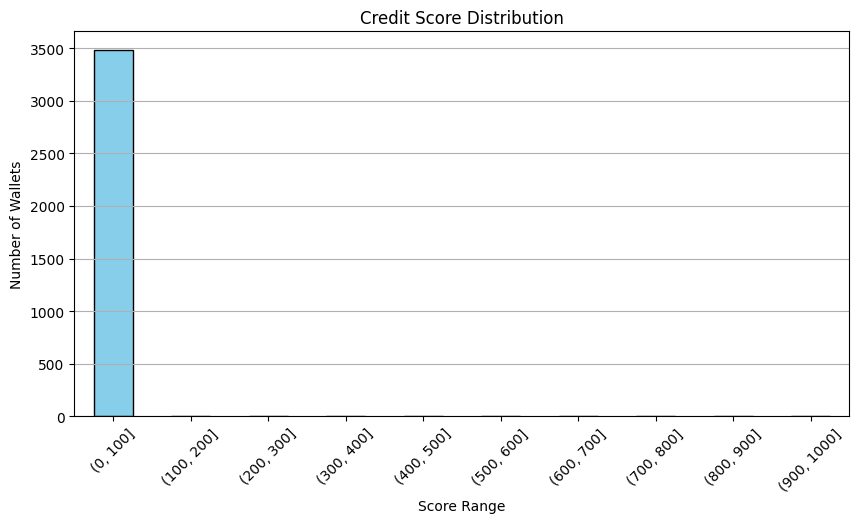

In [10]:
# Distribution by range (0–100, 100–200, ..., 900–1000)
df_scores['score_range'] = pd.cut(df_scores['score'], bins=range(0, 1100, 100))

score_counts = df_scores['score_range'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
score_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Credit Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()